# Setting up the env.


In [1]:
!pip install virtualenv
!virtualenv treatment_project
!source treatment_project/bin/activate
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 42.2 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 919ms
  creator CPython3Posix(dest=/content/treatment_project, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.2.1, setuptools==68.2.0, wheel==0.41.2
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [2]:
import os

##Receiving the input dataset (optional) OR upload via left panel

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data (1).zip


In [ ]:
import zipfile
data_folder = '/content'
# Loop through the uploaded files
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        # Construct the full path for the ZIP file
        zip_file_path = os.path.join(data_folder, filename)

        # Write the uploaded ZIP file to the data folder
        with open(zip_file_path, 'wb') as f:
            f.write(uploaded[filename])

        # Extract the contents of the ZIP file to the data folder
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(data_folder)

        print(f'Successfully extracted and saved {filename} in the data folder.')


Successfully extracted and saved data.zip in the data folder.


# Processing the data. Read the input, identify the boundaries

In [ ]:
import cv2
import tifffile as tiff
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing the folders
data_dir = 'data'

# Get a list of subdirectories (folder names) in the data directory
subdirectories = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
subdirectories

['0', '1', '3', '6']

## Process with montage file

### Function for Recognition of rna progression in each nucleus boundaries


In [ ]:
def get_intensity_of_RNA(rna_region):
    RNA_red_pixels = rna_region[:, :, 2][rna_region[:, :, 2] > 2]
    RNA_red_avg = np.mean(RNA_red_pixels)
    return RNA_red_avg

def get_average_intensity_for_all_region(lst):
    if len(lst) == 0:
        return 0
    else:
        total = sum(lst)
        average = total / len(lst)
        return average

def get_pink_count_from_region(pink_channel):
    #the lower and upper bounds of the pink color range
    lower_pink = np.array([140, 0, 160])
    upper_pink = np.array([255, 100, 255])

    # Create a mask for pixels within the pink color range
    mask = cv2.inRange(pink_channel, lower_pink, upper_pink)

    pink_pixel_count = np.count_nonzero(mask)

    # print("Number of pink pixels:", pink_pixel_count)

    return pink_pixel_count


In [ ]:
def get_RNA_data_within_nucleus(mask_blue, contour, rna_image, nucleus_image, rgb_pink):

    # Get Extract the corresponding region from the rna image based on nucleus
    mask_contour = np.zeros_like(mask_blue.copy())
    cv2.drawContours(mask_contour, [contour], 0, 255, thickness=cv2.FILLED)

    # Get rna area
    rna_region = cv2.bitwise_and(rna_image, rna_image, mask=mask_contour)
    nucleus_channel = cv2.bitwise_and(nucleus_image, nucleus_image, mask=mask_contour)
    pink_channel = cv2.bitwise_and(rgb_pink, rgb_pink, mask=mask_contour)

    pink_pixel_count = get_pink_count_from_region(pink_channel)

    #count of available RNA intensity inside region
    RNA_pixels_count = np.count_nonzero(rna_region[:, :, 2] > 2)
    #print("RNA count: ", RNA_pixels_count)

    if RNA_pixels_count > 0:
        RNA_red_avg = get_intensity_of_RNA(rna_region)
    else:
        RNA_red_avg = 0.0

    return rna_region, RNA_pixels_count, nucleus_channel[:, :, 0], rna_region[:, :, 2], RNA_red_avg, pink_pixel_count

In [ ]:
def Get_Percentage_of_RNA_within_nucleus(RNA_data_count, nucleus_data_count):
    # calculate percentage of RNA within nucleus
    percentage_for_nucleus = (RNA_data_count / nucleus_data_count) * 100
    percentage_for_nucleus = min(percentage_for_nucleus, 100)
    return percentage_for_nucleus

### Function for Identify the boundaries

In [ ]:
def find_nucleus_boundaries(nucleus_image, rna_image, rgb_pink):

  imghsv = cv2.cvtColor(nucleus_image, cv2.COLOR_BGR2HSV)

  lower_blue = np.array([110, 50, 50])
  upper_blue = np.array([130, 255, 255])

  # A mask for the nucleus
  mask_blue = cv2.inRange(imghsv, lower_blue, upper_blue)

  blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  nucleus = np.copy(nucleus_image)
  rna = np.copy(rna_image)

  print("Total nucleus: ", len(blue_contours))

  rna_region_count = 0
  nucleus_region_count = 0
  pink_region_count = 0
  count = 0
  red_i_list = []

  for i, contour in enumerate(blue_contours):

    region_rna, RNA_data_count, nucleus_channel, rna_channel, RNA_I_avg, pink_pixel_count = get_RNA_data_within_nucleus(mask_blue, contour, rna_image, nucleus_image, rgb_pink)

    # get count of data in the nucleus
    nucleus_data_count = cv2.contourArea(contour)
    # print("nucleus count: ", nucleus_data_count)
    # print("RNA_I_avg e: ", RNA_I_avg)

    # print("RNA count: ", RNA_data_count)

    # check valid nucleus
    if nucleus_data_count > 0:

        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(nucleus, (x, y), (x + w, y + h), (0, 255, 0), 1)

        red_i_list.append(RNA_I_avg)

        rna_region_count += RNA_data_count
        nucleus_region_count += nucleus_data_count
        pink_region_count += pink_pixel_count

        percentage_for_nucleus = Get_Percentage_of_RNA_within_nucleus(RNA_data_count, nucleus_data_count)
        percentage_of_nucleus_using_pink = Get_Percentage_of_RNA_within_nucleus(pink_pixel_count, nucleus_data_count)

        # Print the percentage
        print(f"Percentage of RNA in nucleus {i + 1}: {percentage_for_nucleus:.2f}%")

        # Print the percentage using pink color
        print(f"Percentage of RNA in nucleus using pink color {i + 1}: {percentage_of_nucleus_using_pink:.2f}%")

        # generate correlation coefficient between the nucleus and RNA channels
        correlation_coefficient = np.corrcoef(nucleus_channel.flatten(), rna_channel.flatten())[0, 1]

        print(f"Correlation coefficient of nucleus {i + 1} & RNA is : {correlation_coefficient:.4f}")

        cv2.drawContours(nucleus, [contour], -1, (0, 255, 0), 1)
        count += 1
        # Write the red percentage on top of the contour
        cv2.putText(nucleus, f"{percentage_for_nucleus:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

  OverallProgress = Get_Percentage_of_RNA_within_nucleus(rna_region_count, nucleus_region_count)

  OverallIntensity = get_average_intensity_for_all_region(red_i_list)

  OverallProgress_withPink = Get_Percentage_of_RNA_within_nucleus(pink_region_count, nucleus_region_count)

  return nucleus, OverallProgress, OverallIntensity, OverallProgress_withPink, count


### Process on each hour data

Processed parts from folder: 0
Total nucleus:  14
Percentage of RNA in nucleus 1: 1.61%
Percentage of RNA in nucleus using pink color 1: 0.00%
Correlation coefficient of nucleus 1 & RNA is : 0.1046
Percentage of RNA in nucleus 2: 1.48%
Percentage of RNA in nucleus using pink color 2: 0.00%
Correlation coefficient of nucleus 2 & RNA is : 0.1088
Percentage of RNA in nucleus 3: 0.74%
Percentage of RNA in nucleus using pink color 3: 0.00%
Correlation coefficient of nucleus 3 & RNA is : 0.0727
Percentage of RNA in nucleus 4: 1.66%
Percentage of RNA in nucleus using pink color 4: 0.00%
Correlation coefficient of nucleus 4 & RNA is : 0.1273
Percentage of RNA in nucleus 5: 1.42%
Percentage of RNA in nucleus using pink color 5: 0.00%
Correlation coefficient of nucleus 5 & RNA is : 0.1054
Percentage of RNA in nucleus 6: 1.73%
Percentage of RNA in nucleus using pink color 6: 0.00%
Correlation coefficient of nucleus 6 & RNA is : 0.1116
Percentage of RNA in nucleus 7: 1.10%
Percentage of RNA in nuc

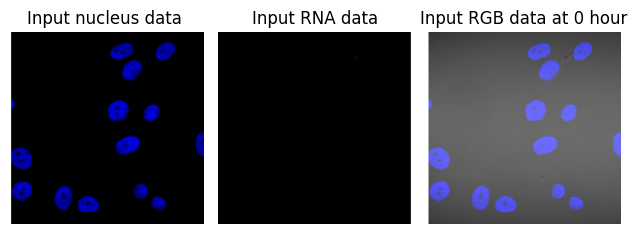

Overall Progress at 0 hour is 2.02 %
Overall Progress at 0 hour is with RGB image (pink color)0.00 %


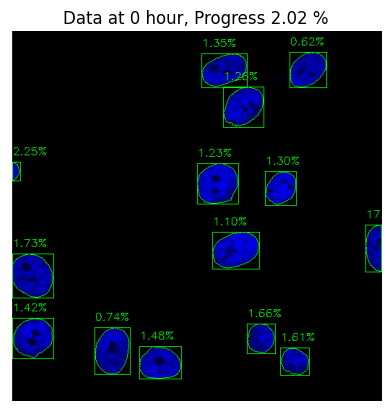

Processed parts from folder: 1
Total nucleus:  12
Percentage of RNA in nucleus 1: 100.00%
Percentage of RNA in nucleus using pink color 1: 5.77%
Correlation coefficient of nucleus 1 & RNA is : 0.7297
Percentage of RNA in nucleus 2: 48.88%
Percentage of RNA in nucleus using pink color 2: 1.58%
Correlation coefficient of nucleus 2 & RNA is : 0.5696
Percentage of RNA in nucleus 3: 64.28%
Percentage of RNA in nucleus using pink color 3: 7.90%
Correlation coefficient of nucleus 3 & RNA is : 0.5563
Percentage of RNA in nucleus 4: 29.72%
Percentage of RNA in nucleus using pink color 4: 0.23%
Correlation coefficient of nucleus 4 & RNA is : 0.3824
Percentage of RNA in nucleus 5: 25.49%
Percentage of RNA in nucleus using pink color 5: 0.21%
Correlation coefficient of nucleus 5 & RNA is : 0.3578
Percentage of RNA in nucleus 6: 18.21%
Percentage of RNA in nucleus using pink color 6: 0.04%
Correlation coefficient of nucleus 6 & RNA is : 0.2677
Percentage of RNA in nucleus 7: 57.46%
Percentage of RN

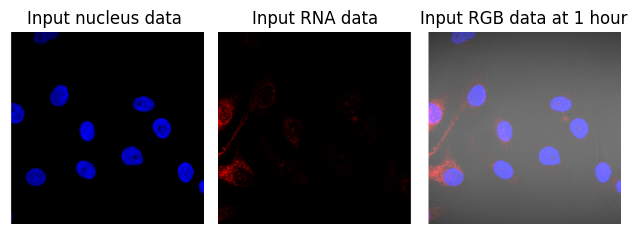

Overall Progress at 1 hour is 42.05 %
Overall Progress at 1 hour is with RGB image (pink color)1.98 %


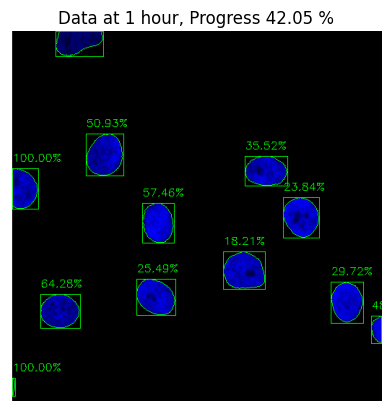

Processed parts from folder: 3
Total nucleus:  18
Percentage of RNA in nucleus 1: 20.73%
Percentage of RNA in nucleus using pink color 1: 0.17%
Correlation coefficient of nucleus 1 & RNA is : 0.3033
Percentage of RNA in nucleus 2: 38.61%
Percentage of RNA in nucleus using pink color 2: 1.09%
Correlation coefficient of nucleus 2 & RNA is : 0.4493
Percentage of RNA in nucleus 3: 33.84%
Percentage of RNA in nucleus using pink color 3: 0.83%
Correlation coefficient of nucleus 3 & RNA is : 0.3999
Percentage of RNA in nucleus 4: 52.47%
Percentage of RNA in nucleus using pink color 4: 2.04%
Correlation coefficient of nucleus 4 & RNA is : 0.5022
Percentage of RNA in nucleus 5: 24.93%
Percentage of RNA in nucleus using pink color 5: 0.06%
Correlation coefficient of nucleus 5 & RNA is : 0.3342
Percentage of RNA in nucleus 6: 30.43%
Percentage of RNA in nucleus using pink color 6: 0.00%
Correlation coefficient of nucleus 6 & RNA is : 0.3908
Percentage of RNA in nucleus 7: 19.92%
Percentage of RNA

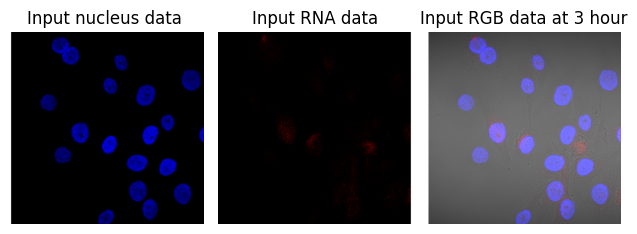

Overall Progress at 3 hour is 36.02 %
Overall Progress at 3 hour is with RGB image (pink color)0.60 %


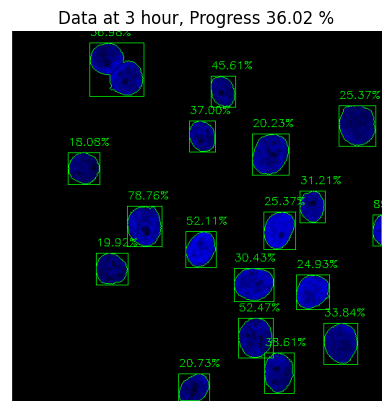

Processed parts from folder: 6
Total nucleus:  15
Percentage of RNA in nucleus 2: 96.21%
Percentage of RNA in nucleus using pink color 2: 45.56%
Correlation coefficient of nucleus 2 & RNA is : 0.7810
Percentage of RNA in nucleus 3: 91.50%
Percentage of RNA in nucleus using pink color 3: 20.75%
Correlation coefficient of nucleus 3 & RNA is : 0.7092
Percentage of RNA in nucleus 4: 79.31%
Percentage of RNA in nucleus using pink color 4: 3.45%
Correlation coefficient of nucleus 4 & RNA is : 0.5574
Percentage of RNA in nucleus 5: 94.62%
Percentage of RNA in nucleus using pink color 5: 17.91%
Correlation coefficient of nucleus 5 & RNA is : 0.7701
Percentage of RNA in nucleus 6: 100.00%
Percentage of RNA in nucleus using pink color 6: 0.30%
Correlation coefficient of nucleus 6 & RNA is : 0.8299
Percentage of RNA in nucleus 7: 95.17%
Percentage of RNA in nucleus using pink color 7: 0.26%
Correlation coefficient of nucleus 7 & RNA is : 0.7695
Percentage of RNA in nucleus 8: 81.41%
Percentage of

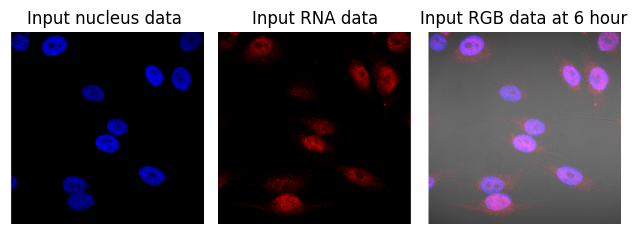

Overall Progress at 6 hour is 95.35 %
Overall Progress at 6 hour is with RGB image (pink color)27.42 %


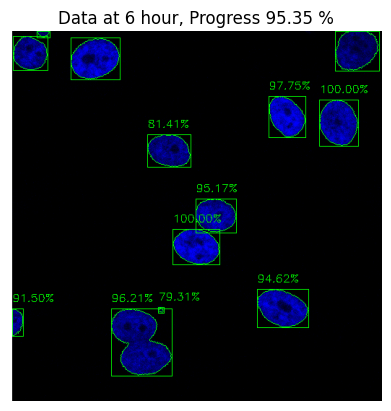

In [ ]:
# lists to store time and progress data
time_data = []
progress_data = []
intensity_data = []
nucleus_total = []

for folder_name in subdirectories:

    tiff_file_path = os.path.join(data_dir, folder_name, 'montage.tif')

    if os.path.isfile(tiff_file_path):

        image = tiff.imread(tiff_file_path)

        opencv_frame = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, channels = opencv_frame.shape

        part_width = width // 5

        divided_images = []

        for i in range(5):
            start_col = i * part_width
            end_col = (i + 1) * part_width
            part_image = opencv_frame[:, start_col:end_col]

            divided_images.append(part_image)

        print(f"Processed parts from folder: {folder_name}")
        nucleus_boundary_img, OverallProgress, OverallIntensity, OverallProgress_withPink, nucleus_count = find_nucleus_boundaries(divided_images[3], divided_images[0], divided_images[-1])


        # show input
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(divided_images[3], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Input nucleus data ')

        plt.subplot(2, 3, 2)
        plt.imshow(cv2.cvtColor(divided_images[0], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Input RNA data')

        plt.subplot(2, 3, 3)
        plt.imshow(cv2.cvtColor(divided_images[-1], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Input RGB data at {folder_name} hour')

        plt.tight_layout()
        plt.show()




        # append time and OverallProgress to the lists
        time_data.append(folder_name)
        progress_data.append(OverallProgress)
        intensity_data.append(OverallIntensity)
        nucleus_total.append(nucleus_count)


        print(f"Overall Progress at {folder_name} hour is {OverallProgress:.2f} %")

        print(f"Overall Progress at {folder_name} hour is with RGB image (pink color){OverallProgress_withPink:.2f} %")


        # plt.subplot(1, num_frames, frame_idx + 1)  # Subplot for each frame
        plt.imshow(cv2.cvtColor(nucleus_boundary_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Data at {folder_name} hour, Progress {OverallProgress:.2f} %')
        # plt.suptitle(f'Images from folder: 1')  # You may want to adjust the title accordingly
        plt.show()


    else:
        print(f"TIFF file not found in folder: {folder_name}")


### RNA progression vs Time

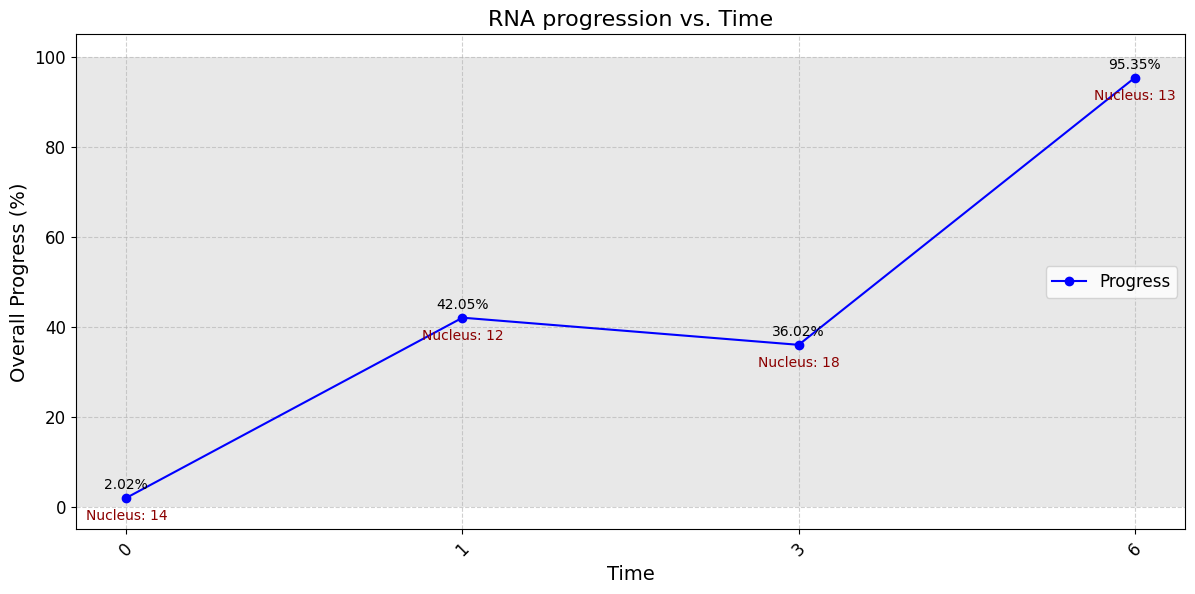

In [ ]:
import matplotlib.pyplot as plt
# Create a plot of Overall Progress vs. Time
plt.figure(figsize=(12, 6))
plt.plot(time_data, progress_data, marker='o', linestyle='-', color='b', label='Progress')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Overall Progress (%)', fontsize=14)
plt.title('RNA progression vs. Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()


plt.legend(loc='best', fontsize=12)


plt.tick_params(axis='both', which='major', labelsize=12)

plt.axhspan(0, 100, facecolor='lightgray', alpha=0.5)

for i, progress in enumerate(progress_data):
    plt.annotate(f'{progress:.2f}%', (time_data[i], progress + 2), ha='center', fontsize=10)
    plt.annotate(f'Nucleus: {nucleus_total[i]}', (time_data[i], progress - 5), ha='center', fontsize=10, color='darkred')

plt.show()

### RNA intensity vs Time

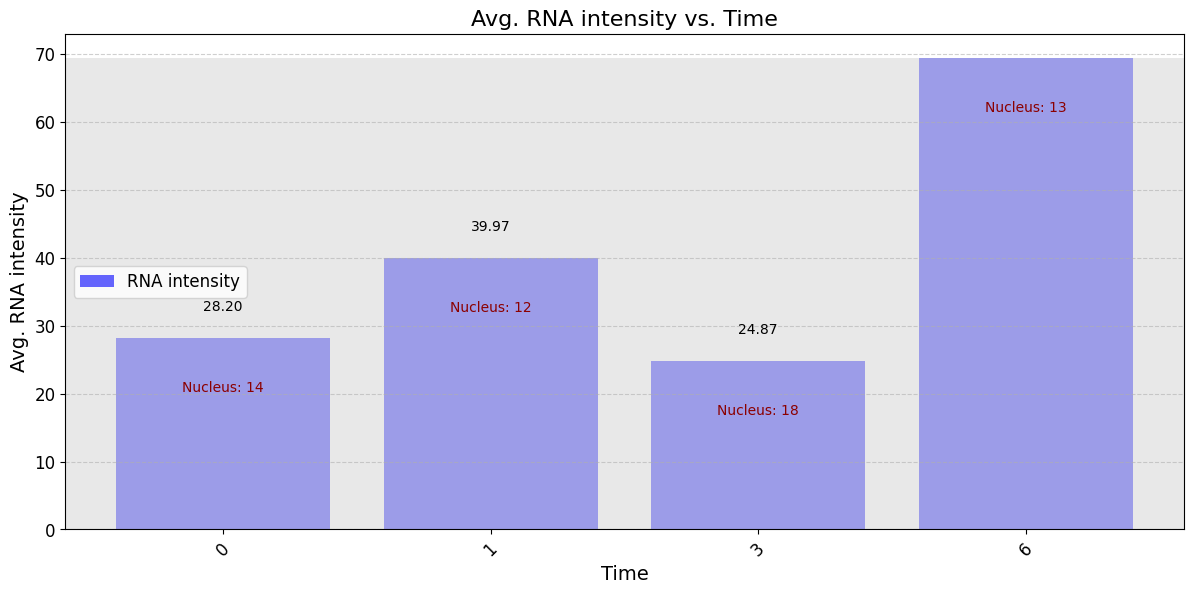

In [ ]:
# create a plot of Avg. RNA intensity vs. Time

plt.figure(figsize=(12, 6))
plt.bar(time_data, intensity_data, color='b', alpha=0.6, label='RNA intensity')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Avg. RNA intensity', fontsize=14)
plt.title('Avg. RNA intensity vs. Time', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

for i, progress in enumerate(intensity_data):
    plt.annotate(f'{progress:.2f}', (time_data[i], progress + 4), ha='center', fontsize=10)
    plt.annotate(f'Nucleus: {nucleus_total[i]}', (time_data[i], progress - 8), ha='center', fontsize=10, color='darkred')

plt.legend(loc='best', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.axhspan(0, max(intensity_data), facecolor='lightgray', alpha=0.5)

plt.show()


## Process with lsm file

### Test lsm files

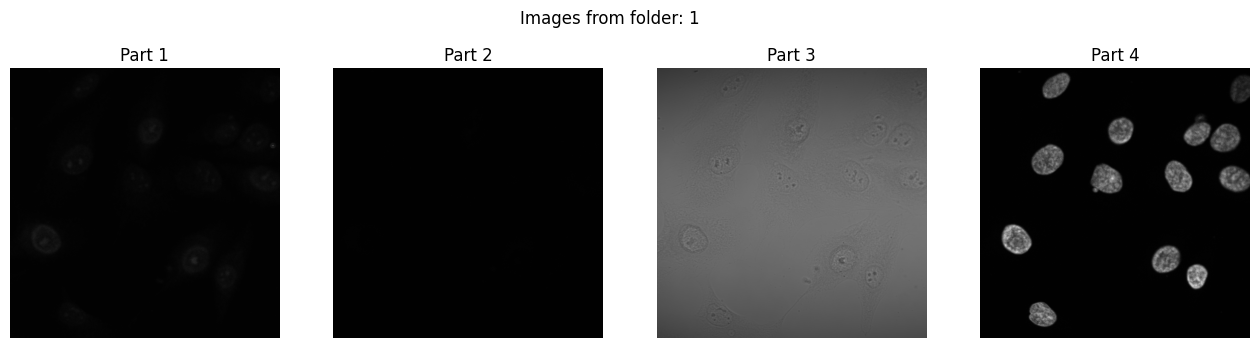

In [ ]:
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt

lsm_image = tiff.imread('data/1/1.lsm')

# Calculate the number of frames
num_frames = len(lsm_image)

# Create a single subplot with multiple columns for each frame
plt.figure(figsize=(16, 4))  # Adjust the figure size as needed

for frame_idx, frame in enumerate(lsm_image):
    opencv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    plt.subplot(1, num_frames, frame_idx + 1)  # Subplot for each frame
    plt.imshow(cv2.cvtColor(opencv_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Part {frame_idx + 1}')

plt.suptitle(f'Images from folder: 1')  # You may want to adjust the title accordingly
plt.show()


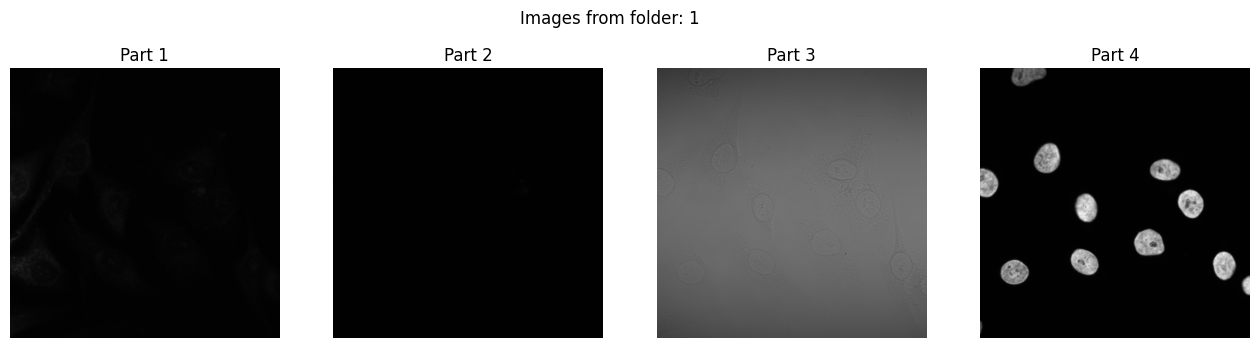

In [ ]:
lsm_image = tiff.imread('data/1/4.lsm')

# Calculate the number of frames
num_frames = len(lsm_image)

# Create a single subplot with multiple columns for each frame
plt.figure(figsize=(16, 4))  # Adjust the figure size as needed

for frame_idx, frame in enumerate(lsm_image):
    opencv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    plt.subplot(1, num_frames, frame_idx + 1)  # Subplot for each frame
    plt.imshow(cv2.cvtColor(opencv_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Part {frame_idx + 1}')

plt.suptitle(f'Images from folder: 1')  # You may want to adjust the title accordingly
plt.show()

### Function for Recognition of rna progression in each nucleus boundaries for lsm



In [ ]:
def get_RNA_data_within_nucleus_lsm(mask_blue, contour, rna_image, nucleus_image):

    # Get Extract the corresponding region from the rna image based on nucleus
    mask_contour = np.zeros_like(mask_blue)
    cv2.drawContours(mask_contour, [contour], 0, 255, thickness=cv2.FILLED)

    # Get rna area
    rna_region = cv2.bitwise_and(rna_image, rna_image, mask=mask_contour)
    nucleus_channel = cv2.bitwise_and(nucleus_image, nucleus_image, mask=mask_contour)

    # plt.imshow(cv2.cvtColor(mask_contour, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.title(f'mask_contour')
    # plt.show()


    # Count of available RNA values inside region
    RNA_pixels_count = np.count_nonzero(rna_region[:, :, 2] > 5)
    # print("RNA count: ", RNA_pixels_count)

    return rna_region, RNA_pixels_count, nucleus_channel[:, :, 0], rna_region[:, :, 2]

In [ ]:
def Get_Percentage_of_RNA_within_nucleus_lsm(RNA_data_count, nucleus_data_count):
    # calculate percentage of RNA within nucleus
    percentage_for_nucleus = (RNA_data_count / nucleus_data_count) * 100
    percentage_for_nucleus = min(percentage_for_nucleus, 100)
    return percentage_for_nucleus

### Function for Identify the boundaries for LSM

In [ ]:
def find_nucleus_boundaries_lsm(nucleus_image, rna_image):

  min_width_threshold = 25

  imghsv = cv2.cvtColor(nucleus_image, cv2.COLOR_BGR2HSV)

  lower_blue = np.array([110, 50, 50])
  upper_blue = np.array([130, 255, 255])

  # A mask for the nucleus
  mask_blue = cv2.inRange(imghsv, lower_blue, upper_blue)

  blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  count_nucleus = 0
  nucleus = np.copy(nucleus_image)

  rna_region_count = 0
  nucleus_region_count = 0


  for i, contour in enumerate(blue_contours):

    x, y, w, h = cv2.boundingRect(contour)

    # check valid nucleus
    if w >= min_width_threshold:

        region_rna, RNA_data_count, nucleus_channel, rna_channel = get_RNA_data_within_nucleus_lsm(mask_blue, contour, rna_image, nucleus_image)

        nucleus_data_count = cv2.contourArea(contour)

        rna_region_count += RNA_data_count
        nucleus_region_count += nucleus_data_count

        # print("nucleus count: ", nucleus_data_count)

        # print("RNA count: ", RNA_data_count)

        percentage_for_nucleus = Get_Percentage_of_RNA_within_nucleus_lsm(RNA_data_count, nucleus_data_count)

        # Print the percentage
        print(f"Percentage of RNA in nucleus {i + 1}: {percentage_for_nucleus:.2f}%")
        # generate correlation coefficient between the nucleus and RNA channels
        correlation_coefficient = np.corrcoef(nucleus_channel.flatten(), rna_channel.flatten())[0, 1]

        print(f"Correlation coefficient of nucleus {i + 1} & RNA is : {correlation_coefficient:.4f}")

        cv2.drawContours(nucleus, [contour], -1, (0, 255, 0), 2)
        cv2.rectangle(nucleus, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Write the red percentage on top of the contour
        cv2.putText(nucleus, f"{percentage_for_nucleus:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)

        count_nucleus += 1

  OverallProgress = Get_Percentage_of_RNA_within_nucleus_lsm(rna_region_count, nucleus_region_count)

  return nucleus, count_nucleus, OverallProgress


### Process on each hour data

Process at time / folder: 0 hour
Percentage of RNA in nucleus 168: 1.90%
Correlation coefficient of nucleus 168 & RNA is : 0.8760
Percentage of RNA in nucleus 190: 1.45%
Correlation coefficient of nucleus 190 & RNA is : 0.9019
Percentage of RNA in nucleus 272: 7.60%
Correlation coefficient of nucleus 272 & RNA is : 0.8176
Percentage of RNA in nucleus 298: 7.09%
Correlation coefficient of nucleus 298 & RNA is : 0.8258
Percentage of RNA in nucleus 317: 1.09%
Correlation coefficient of nucleus 317 & RNA is : 0.8976
Percentage of RNA in nucleus 421: 1.04%
Correlation coefficient of nucleus 421 & RNA is : 0.9147
Percentage of RNA in nucleus 470: 5.44%
Correlation coefficient of nucleus 470 & RNA is : 0.8446
Percentage of RNA in nucleus 478: 1.03%
Correlation coefficient of nucleus 478 & RNA is : 0.9157
Percentage of RNA in nucleus 589: 6.62%
Correlation coefficient of nucleus 589 & RNA is : 0.8250
Percentage of RNA in nucleus 618: 6.91%
Correlation coefficient of nucleus 618 & RNA is : 0.82

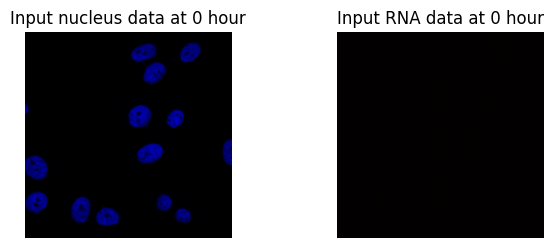

Overall Progress at 0 hour is 4.80 %
Total nucleus:  14


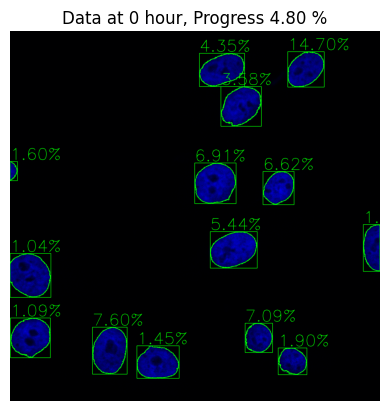

Process at time / folder: 1 hour
Percentage of RNA in nucleus 66: 2.05%
Correlation coefficient of nucleus 66 & RNA is : 0.8771
Percentage of RNA in nucleus 118: 4.69%
Correlation coefficient of nucleus 118 & RNA is : 0.8543
Percentage of RNA in nucleus 158: 4.51%
Correlation coefficient of nucleus 158 & RNA is : 0.8395
Percentage of RNA in nucleus 166: 1.86%
Correlation coefficient of nucleus 166 & RNA is : 0.9002
Percentage of RNA in nucleus 196: 28.17%
Correlation coefficient of nucleus 196 & RNA is : 0.6760
Percentage of RNA in nucleus 289: 8.94%
Correlation coefficient of nucleus 289 & RNA is : 0.8107
Percentage of RNA in nucleus 300: 8.92%
Correlation coefficient of nucleus 300 & RNA is : 0.8133
Percentage of RNA in nucleus 362: 1.97%
Correlation coefficient of nucleus 362 & RNA is : 0.9031
Percentage of RNA in nucleus 399: 46.82%
Correlation coefficient of nucleus 399 & RNA is : 0.7928
Percentage of RNA in nucleus 441: 79.20%
Correlation coefficient of nucleus 441 & RNA is : 0.8

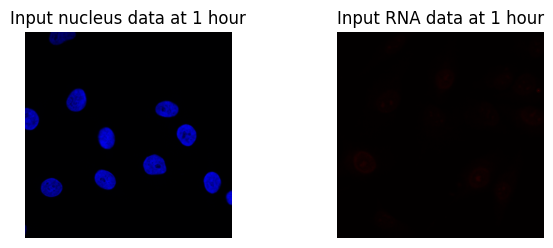

Overall Progress at 1 hour is 19.95 %
Total nucleus:  11


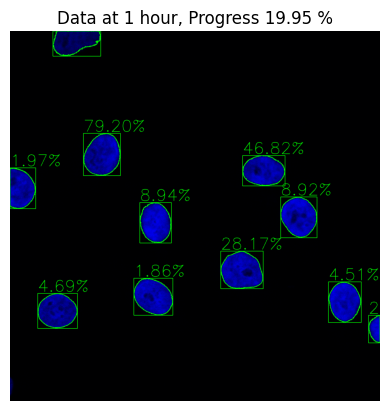

Process at time / folder: 3 hour
Percentage of RNA in nucleus 50: 23.95%
Correlation coefficient of nucleus 50 & RNA is : 0.7880
Percentage of RNA in nucleus 122: 1.96%
Correlation coefficient of nucleus 122 & RNA is : 0.8854
Percentage of RNA in nucleus 193: 13.06%
Correlation coefficient of nucleus 193 & RNA is : 0.7702
Percentage of RNA in nucleus 204: 3.07%
Correlation coefficient of nucleus 204 & RNA is : 0.8657
Percentage of RNA in nucleus 291: 40.47%
Correlation coefficient of nucleus 291 & RNA is : 0.8040
Percentage of RNA in nucleus 313: 15.06%
Correlation coefficient of nucleus 313 & RNA is : 0.7790
Percentage of RNA in nucleus 366: 5.95%
Correlation coefficient of nucleus 366 & RNA is : 0.8326
Percentage of RNA in nucleus 447: 3.02%
Correlation coefficient of nucleus 447 & RNA is : 0.8686
Percentage of RNA in nucleus 510: 23.03%
Correlation coefficient of nucleus 510 & RNA is : 0.8017
Percentage of RNA in nucleus 530: 2.01%
Correlation coefficient of nucleus 530 & RNA is : 0

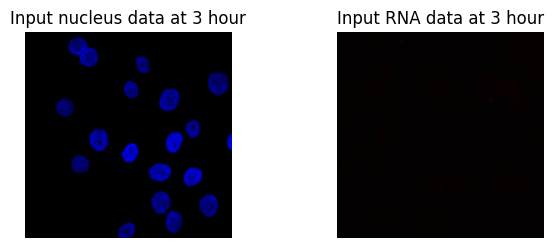

Overall Progress at 3 hour is 14.06 %
Total nucleus:  18


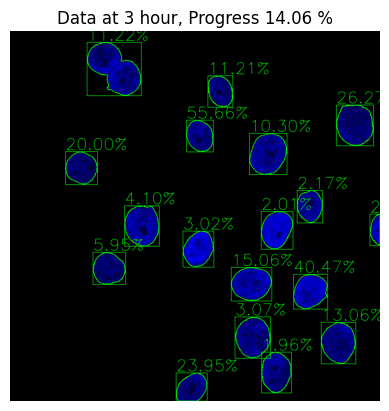

Process at time / folder: 6 hour
Percentage of RNA in nucleus 331: 71.27%
Correlation coefficient of nucleus 331 & RNA is : 0.8003
Percentage of RNA in nucleus 332: 16.28%
Correlation coefficient of nucleus 332 & RNA is : 0.7954
Percentage of RNA in nucleus 412: 31.00%
Correlation coefficient of nucleus 412 & RNA is : 0.7807
Percentage of RNA in nucleus 492: 54.65%
Correlation coefficient of nucleus 492 & RNA is : 0.7506
Percentage of RNA in nucleus 575: 52.70%
Correlation coefficient of nucleus 575 & RNA is : 0.7987
Percentage of RNA in nucleus 691: 54.75%
Correlation coefficient of nucleus 691 & RNA is : 0.7602
Percentage of RNA in nucleus 818: 49.01%
Correlation coefficient of nucleus 818 & RNA is : 0.7469
Percentage of RNA in nucleus 832: 61.86%
Correlation coefficient of nucleus 832 & RNA is : 0.8015
Percentage of RNA in nucleus 1297: 20.34%
Correlation coefficient of nucleus 1297 & RNA is : 0.7852
Percentage of RNA in nucleus 1365: 71.94%
Correlation coefficient of nucleus 1365 &

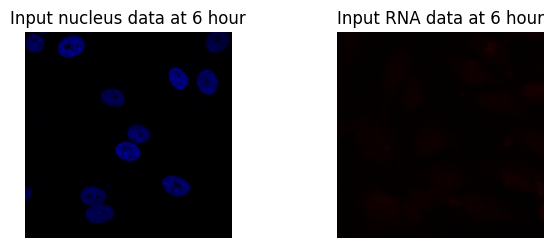

Overall Progress at 6 hour is 51.33 %
Total nucleus:  12


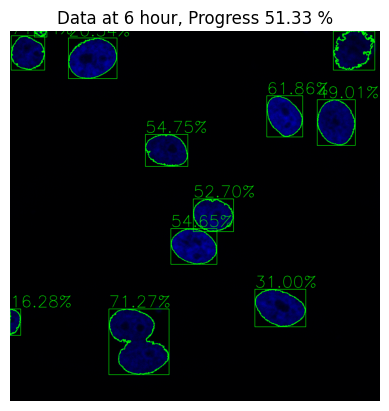

In [ ]:
# lists to store time and progress data
time_data = []
progress_data = []
nucleus_total = []

for folder_name in subdirectories:

    # Assuming rna file path 1.lsm first frame have rna details
    rna_file_path = os.path.join(data_dir, folder_name, '1.lsm')

    # Assuming nucleus file path 4.lsm 4th frame have nucleus details
    nucleus_file_path = os.path.join(data_dir, folder_name, '4.lsm')

    if os.path.isfile(nucleus_file_path):

        lsm_image = tiff.imread(nucleus_file_path)

        rna_file =  tiff.imread(rna_file_path)

        num_frames = len(lsm_image)
        # print(num_frames)

        # get nucleus frame
        nucleus_frame = cv2.cvtColor(lsm_image[-1], cv2.COLOR_RGB2BGR)

        # Split the last frame into its RGB channels
        b, g, r = cv2.split(nucleus_frame)

        b_channel = np.ones_like(b)
        g_channel = np.zeros_like(g)
        r_channel = np.zeros_like(r)

        # visual transformation nucleus
        nucleus_image = cv2.merge((b, g_channel, r_channel))

        print(f"Process at time / folder: {folder_name} hour")

        # height, width, channels = nucleus_image.shape
        # print(height, width, channels)

        # get rna frame
        rna_frame = cv2.cvtColor(rna_file[0], cv2.COLOR_RGB2BGR)

        rna_b, rna_g, rna_r = cv2.split(rna_frame)

        b_channel = np.zeros_like(b)
        g_channel = np.zeros_like(g)
        r_channel = np.zeros_like(r)

        # visual transformation RNA
        rna_image = cv2.merge((b_channel, g_channel, rna_r))




        nucleus_boundary_img, count_nucleus, OverallProgress = find_nucleus_boundaries_lsm(nucleus_image, rna_image)

        # view nucleus and RNA from lsm

        plt.subplot(2, 2, 1)
        plt.imshow(cv2.cvtColor(nucleus_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Input nucleus data at {folder_name} hour')

        plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(rna_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Input RNA data at {folder_name} hour')

        plt.tight_layout()
        plt.show()



        print(f"Overall Progress at {folder_name} hour is {OverallProgress:.2f} %")

        print("Total nucleus: ", count_nucleus)

        # append time and OverallProgress to the lists
        time_data.append(folder_name)
        progress_data.append(OverallProgress)
        nucleus_total.append(count_nucleus)


        # plt.subplot(1, num_frames, frame_idx + 1)  # Subplot for each frame
        plt.imshow(cv2.cvtColor(nucleus_boundary_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Data at {folder_name} hour, Progress {OverallProgress:.2f} %')
        # plt.suptitle(f'Images from folder: 1')  # You may want to adjust the title accordingly
        plt.show()
        # break

    else:
        print(f"Lsm file not found in folder: {folder_name}")


### RNA progression vs Time

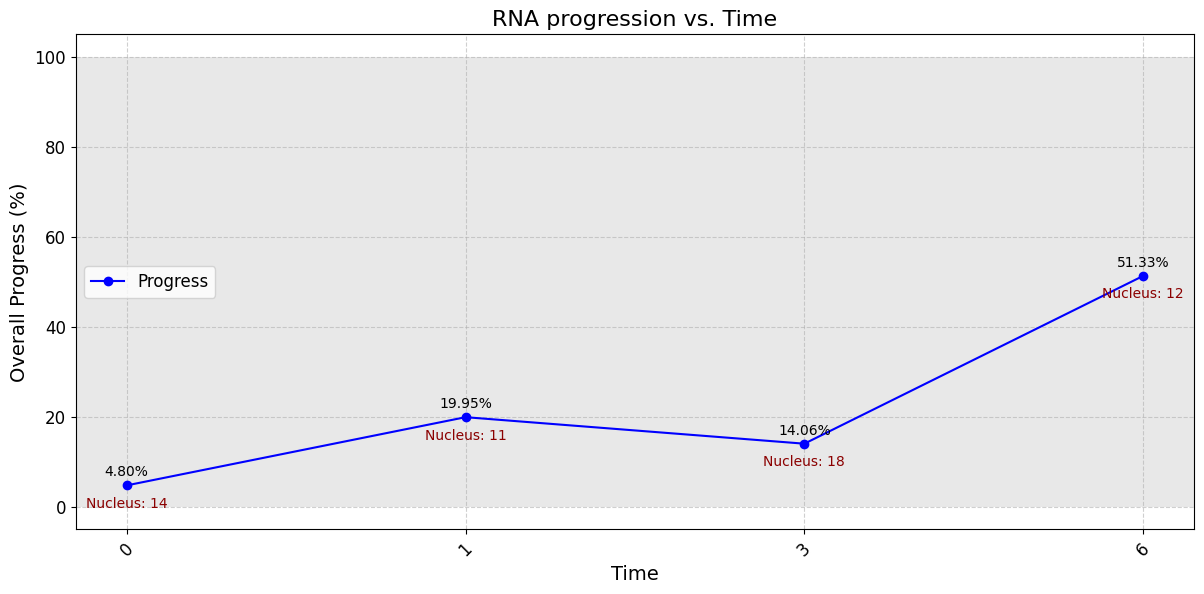

In [ ]:
import matplotlib.pyplot as plt
# Create a plot of Overall Progress vs. Time
plt.figure(figsize=(12, 6))
plt.plot(time_data, progress_data, marker='o', linestyle='-', color='b', label='Progress')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Overall Progress (%)', fontsize=14)
plt.title('RNA progression vs. Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()


plt.legend(loc='best', fontsize=12)


plt.tick_params(axis='both', which='major', labelsize=12)

plt.axhspan(0, 100, facecolor='lightgray', alpha=0.5)

for i, progress in enumerate(progress_data):
    plt.annotate(f'{progress:.2f}%', (time_data[i], progress + 2), ha='center', fontsize=10)
    plt.annotate(f'Nucleus: {nucleus_total[i]}', (time_data[i], progress - 5), ha='center', fontsize=10, color='darkred')

plt.show()